In [12]:
using Plots

pyplot();

In [26]:
function base_plot(X, Y)
    scatter(
        x = X[:, 2], xlabel = "Exam 1 score", xlimits = (10, 70),
        y = X[:, 3], ylabel = "Exam 2 score", ylims = (40, 100),
        group = map((y) -> ["Not admitted", "Admitted"][y+1], Y),
        markercolor = [colorant"Red" colorant"LawnGreen"],
        size = (500, 500) )
end

function contour_plot(X, Y, θ)
    plt = base_plot(X, Y)
    plot!(
        plt,
        linspace(10, 70),
        linspace(40, 100),
        (x, y) -> sigmoid(dot([1, x, y], θ)) )
end
;

In [19]:
Y = convert(AbstractVector{Int}, vec(readdlm("ex4y.dat")))
N = length(Y)
X = [ones(N) readdlm("ex4x.dat")];

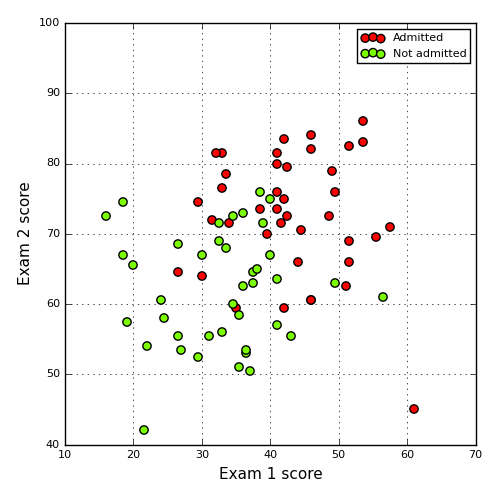

In [20]:
base_plot(X, Y)

In [21]:
function sigmoid(a)
    1 ./ (1 .+ exp(-a))
end

function h(xₙ::AbstractVector, θ::AbstractVector)
    sigmoid(dot(xₙ, θ))
end

function h(X::AbstractMatrix, θ::AbstractVector)
    sigmoid(X * θ)
end

function cost(X, Y, θ)
    sum(-Y .* log(h(X, θ)) - (1 .- Y) .* log(1 - h(X, θ))) / length(Y)
end

function gradient(X, Y, θ)
    vec(sum((h(X, θ) .- Y) .* X, 1)) / length(Y)
end

function Hessian(X::AbstractMatrix, Y::AbstractVector, θ::AbstractVector)
    c = h(X, θ) .* (1 - h(X, θ))
    
    H = zeros(Float64, (length(θ), length(θ)))
    
    for i in 1:length(c)
        H .+= c[i] .* X[i, :]' * X[i, :]
    end
    
    return H ./ length(Y)
end

function Newtons(X, Y, θ)
    I = 1000
    
    J = Array{Float64}(I)
    J[1] = cost(X, Y, θ)
    
    for i in 2:I
        ∇J = gradient(X, Y, θ)
        H = Hessian(X, Y, θ)
        
        δ = H \ ∇J
        
        θ -= δ
        
        J[i] = cost(X, Y, θ)
        
        if norm(J[i] - J[i-1]) < 1e-9
            return (θ, J[1:i])
        end
    end

    error("Failed to converge after $I iterations")
end

;

In [22]:
(θ, J) = Newtons(X, Y, [0, 0, 0])

(θ, length(J))

([-16.37874341028793,0.14834077372487756,0.15890845179345234],7)

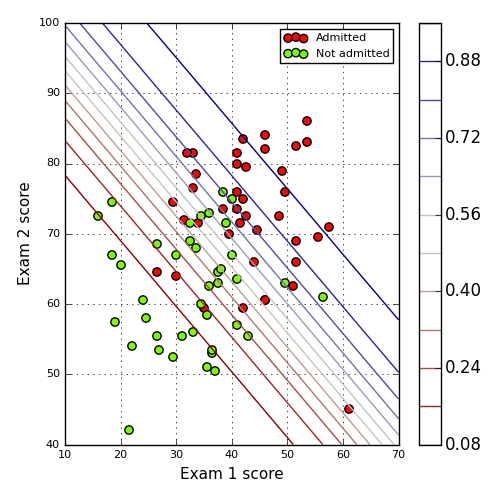

In [27]:
contour_plot(X, Y, θ)

In [9]:
println("θ₀ = $(θ[1])");
println("θ₁ = $(θ[2])");
println("θ₂ = $(θ[3])");

θ₀ = -16.37874341028793
θ₁ = 0.14834077372487756
θ₂ = 0.15890845179345234


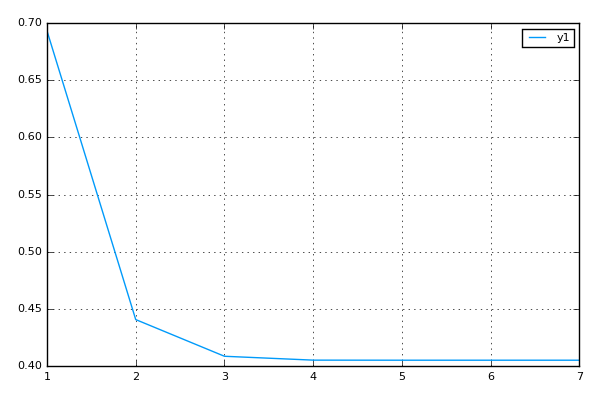

In [10]:
plot(J)

In [11]:
1 - sigmoid(θ' * [1, 20, 80])

1-element Array{Float64,1}:
 0.668022